### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 21 is here the size of the considered amino acid alphabet.


In [1]:
import numpy as np
import pickle
import tensorflow as tf
import logomaker
from time import time
from tqdm import tqdm
from IPython.display import Audio

import importlib
import sequtils as su
print(importlib.reload(su))
import seq
print(importlib.reload(seq))

print(tf.__version__)

%load_ext memory_profiler

2022-03-11 16:16:38.524802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-11 16:16:38.524874: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<module 'sequtils' from '/home/mario/Dropbox/learn_specific_profiles/sequtils.py'>
<module 'seq' from '/home/mario/Dropbox/learn_specific_profiles/seq.py'>
2.7.0


### Create random genomes as toy data 

In [2]:
N = 8            # number of genomes
tile_size = 334  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

#genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
#insertPatterns = ["ATGATGATG", "CCCCCCCCCCCC"]
#genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns, mutationProb=0.2, verbose=True)

genome_sizes = [[10000]] * N
                # in nucleotides
insertPatterns = ["ATGGCAAGAATTCAATCTACTGCAAATAAAGAA"]
repeatPatterns = ['AGAGAACCTGAAGCTACTGCTGAACCTGAAAGA']
genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns,
                               repeatPatterns,
                               mutationProb=0.0, verbose=False)

In [3]:
if insertPatterns is not None:
    desiredPatternAA = []
    for pattern in insertPatterns:
        desiredPatternAA.extend(su.six_frame_translation(pattern))
    
    print("Desired:", desiredPatternAA)
    
if repeatPatterns is not None:
    repeatPatternAA = []
    for pattern in repeatPatterns:
        repeatPatternAA.extend(su.six_frame_translation(pattern))

    print("Repeat:", repeatPatternAA)

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


---

#### Interlude: Magic Commands

https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

`%time command` prints runtime of command  
`%prun command` profiler for command, what steps take how much time? Adds overhead  
`%memit command` peak memory usage and memory increment  
`%mprun command` memory profiling

---

In [4]:
# Load Real Data
if False:
    from Bio import SeqIO
    import os
    
    files = ['hg38.fa', 'mm10.fa', 'hetGla2.fa', 'macFas5.fa']
    genomes = [[] for _ in range(len(files))]
    datapath = "/nas-hs/projs/seedFinding/data/20210517_flanked/"
    def loadRealGenomes(genomes=genomes):
        for i in range(len(files)):
            genomes[i].extend([str(seq.seq) for seq in SeqIO.parse(os.path.join(datapath, files[i]), 'fasta')])
            
    %memit loadRealGenomes()
    
    # load pickled Q to safe time
    Qfile = os.path.join(datapath, "backgroundAAFreqs.pkl4")
    if not os.path.isfile(Qfile):
        print("Getting Q")
        %time Q = seq.backGroundAAFreqs(genomes, True)
        with open(Qfile, 'wb') as fh:
            pickle.dump(Q, fh, protocol=4)
            
    else:
        with open(Qfile, 'rb') as fh:
            Q = pickle.load(fh)
    
else:
    %time Q = seq.backGroundAAFreqs(genomes, True)

background freqs:  159968.0 *
C 0.0316
K 0.0319
E 0.0335
W 0.0144
T 0.0620
G 0.0597
Y 0.0310
A 0.0623
I 0.0457
N 0.0311
V 0.0620
H 0.0303
S 0.0966
D 0.0306
F 0.0331
M 0.0153
R 0.0931
L 0.0958
P 0.0598
Q 0.0324
* 0.0477
CPU times: user 128 ms, sys: 1.01 ms, total: 129 ms
Wall time: 127 ms


For seedFinding data on gs3

    background freqs:  765611260.0 *
    C 0.0329
    K 0.0412
    E 0.0332
    W 0.0165
    T 0.0578
    G 0.0558
    Y 0.0334
    A 0.0510
    I 0.0546
    N 0.0361
    V 0.0578
    H 0.0321
    S 0.0929
    D 0.0280
    F 0.0406
    M 0.0172
    R 0.0710
    L 0.1039
    P 0.0558
    Q 0.0352
    * 0.0527
    CPU times: user 7min 14s, sys: 1.69 s, total: 7min 16s
    Wall time: 7min 16s

In [5]:
len(genomes[0][0])

10000

In [6]:
# uniform background distribution appears to be rather better
Q = np.ones(21, dtype=np.float32)/21

#### Read in the genome

In [7]:
genomes[0][0][0:100]

'ACAGGATTTAATGGGCAACGATACACGTGCTGTATCGATTTCTACCTCGTGGGGAACCAGCCACAATGGAAGCACATGCCAAATTGATTAGAATATAACC'

six frame translation in batch mode:

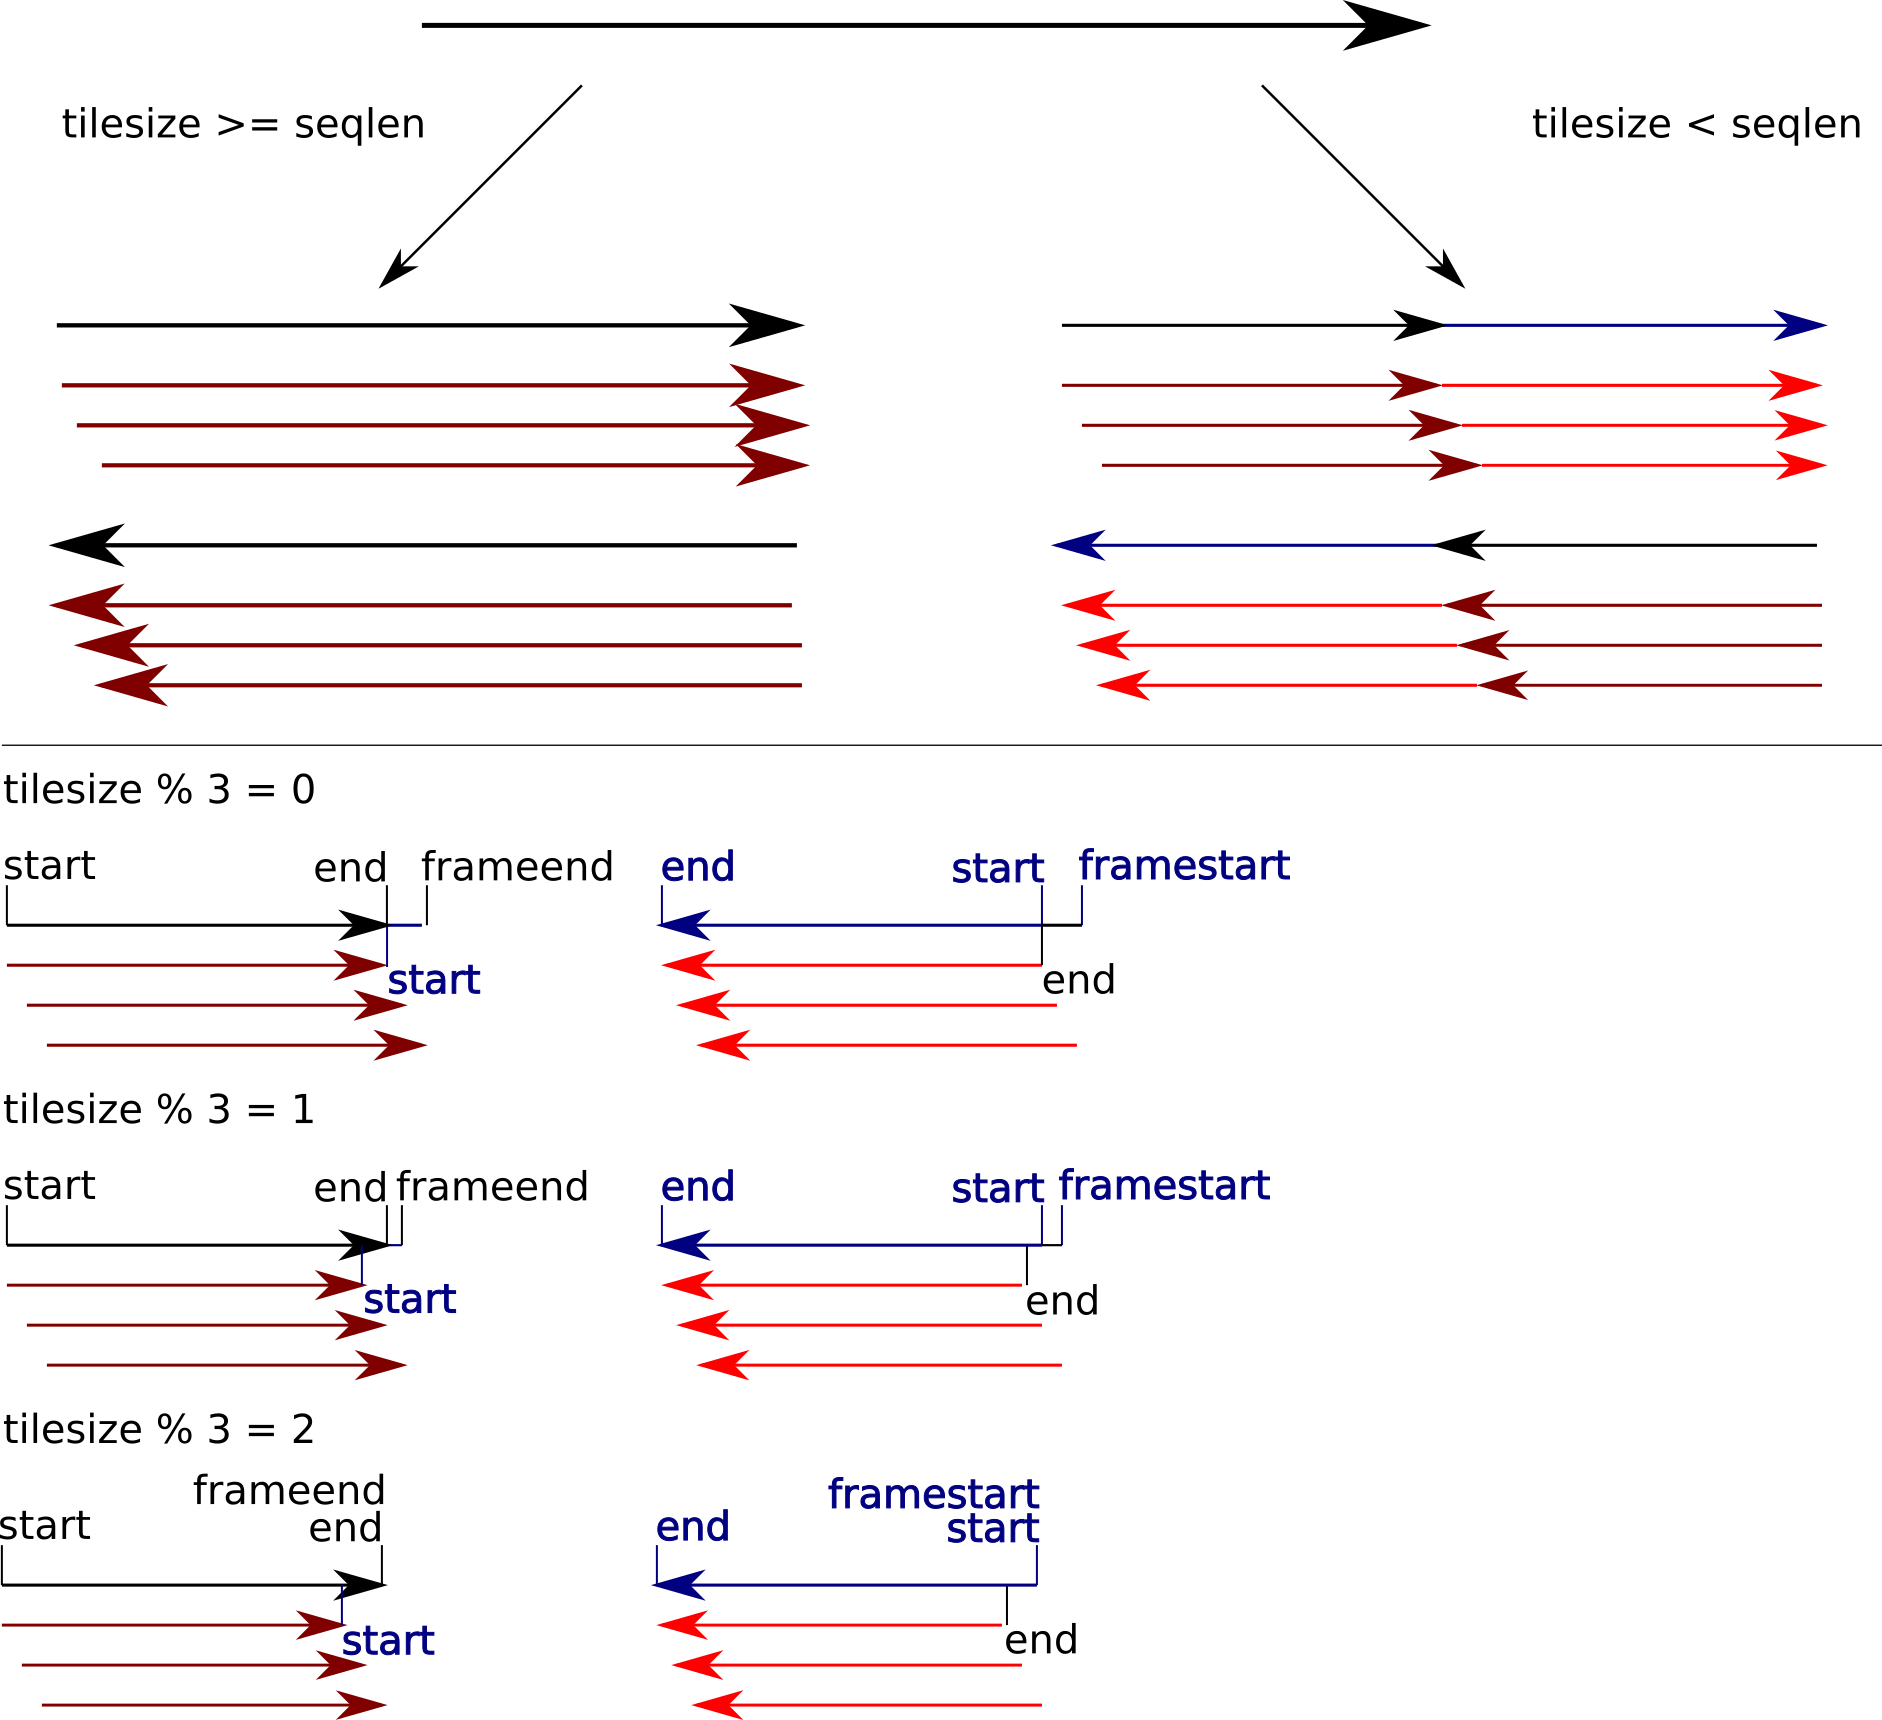

In [8]:
# manually handle reverse complements, assume that len(S) = x*3 + 2
def three_frame_translation(S):
    assert len(S) % 3 == 2, str(len(S))+" % 3 = "+str(len(S)%3)+"\n\n'"+str(S)+"'"
    T = []
    for f in range(3): # frame
        prot = ""
        for i in range(f, len(S)-3+1, 3):
            codon = S[i:i+3]
            if codon not in su.genetic_code: # real sequences may contain N's or softmasking or ambiguous bases
                prot += ' '                  # use null aa in that case
            else:
                prot += su.genetic_code[codon]
        T.append(prot)
    return T

def translateSequences(fwdSeq, pre_rcSeq, startPadding: bool):
    rcSeq = pre_rcSeq[::-1].translate(su.rctbl)
    if startPadding:
        rcSeq += '  ' # add padding
        
    fwdSeq += ' '*(2-(len(fwdSeq)%3)) # add padding such that len%3==2
    rcSeq = ' '*(2-(len(rcSeq)%3)) + rcSeq

    # some nucleotides are part of both neighboring tiles
    aa_seqs_fwd = three_frame_translation(fwdSeq)
    aa_seqs_rc  = three_frame_translation(rcSeq)
    aa_seqs_fwd.extend(aa_seqs_rc)
    return aa_seqs_fwd

# try using a generator to get genome batches
#def createBatch(genomes, ntiles, aa_tile_size: int):
def createBatch(ntiles, aa_tile_size: int, genomes = genomes):
    assert aa_tile_size >= 1, "aa_tile_size must be positive, non-zero (is: "+str(aa_tile_size)+")"
    tile_size = aa_tile_size * 3 # tile_size % 3 always 0
    N = len(genomes)
    state = [{'idx': 0, 'pos': 0, 'exhausted': (len(seqs) == 0)} for seqs in genomes]
    while not all(s['exhausted'] for s in state):
        X = np.zeros([ntiles, N, 6, aa_tile_size, su.aa_alphabet_size], dtype=np.float32)
        I = np.eye(su.aa_alphabet_size + 1) # for numpy-style one-hot encoding
        for t in range(ntiles):
            for i in range(N):
                if state[i]['exhausted']:
                    continue
                    
                sidx = state[i]['idx']
                slen = len(genomes[i][sidx])
                
                start = state[i]['pos']
                end = min(slen, start+tile_size)
                framestart = max(0, start-2)
                frameend = min(slen, end+2)
                assert start < end
                assert framestart < end
                
                # update state
                state[i]['pos'] = end
                if end == slen:
                    state[i]['idx'] += 1
                    state[i]['pos'] = 0
                    
                if state[i]['idx'] == len(genomes[i]):
                    state[i]['exhausted'] = True
                                
                # translate and add tiles
                sequence = genomes[i][sidx]
                if type(sequence) is not str:
                    sequence = str(sequence) # with tf, input are byte-strings and need to be converted back
                    
                aa_seqs = translateSequences(sequence[start:frameend], 
                                             sequence[framestart:end],
                                             (start ==0))
                for frame in range(6):
                    aa_seq = aa_seqs[frame]
                    assert len(aa_seq) <= aa_tile_size, str(len(aa_seq))+" != "+str(aa_tile_size)+", start, end, frameend, slen, tile, genome, frame: "+str((start, end, frameend, slen, t, i, frame))                        
                    x = su.to_idx(aa_seq, su.aa_idx)
                    num_aa = x.shape[0]
                    if (num_aa > 0):
                        one_hot = I[x] # here still aa_alphabet_size + 1 entries
                        # missing sequence will be represented by an all-zero vector
                        one_hot = one_hot[:,1:] 
                        X[t,i,frame,0:num_aa,:] = one_hot
                        
        yield X

---

_**Test Batch Generator**_

Retranslate and assemble all batches, compare to translations of genome sequences

_So far, fails for seedFinding data, no idea why_

In [9]:
# limit test to subset of sequences for large genomes
if max([sum([len(s) for s in genome]) for genome in genomes]) > 100000:
    testgenome = [[]]*len(genomes)
    while max([sum([len(s) for s in genome]) for genome in testgenome]) <= 100000:
        i = 0
        for g in range(len(genomes)):
            if i < len(genomes[g]):
                testgenome[g].append(genomes[g][i])
                
        i += 1
else:
    testgenome = [[s for s in genome] for genome in genomes]
    
# translate and concatenate whole testgenome aa sequences
genome_aa = [[""]*6 for _ in range(len(testgenome))]
for g in range(len(testgenome)):
    for i in range(len(testgenome[g])):
        aa_seqs = su.six_frame_translation(testgenome[g][i])
        for f in range(len(aa_seqs)):
            genome_aa[g][f] += aa_seqs[f].replace(' ', '')#.lstrip().rstrip()

# prepare generator testing
rev_aa_idx = dict((i,c) for i,c in enumerate(su.aa_alphabet))

def to_aa(onehot):
    assert onehot.shape[1] == 21, str(onehot.shape)
    aa_seq = ""
    for c in range(onehot.shape[0]):
        if np.max(onehot[c,:]) != 1:
            continue
        else:
            aa_idx = np.argmax(onehot[c,:])
            assert onehot[c, aa_idx] == 1, str(onehot[c,:])+", "+str(aa_idx)+", "+str(onehot[c,aa_idx])
            aa_idx += 1 # argmax + 1 as in translation, empty aa is cut out
            aa_seq += rev_aa_idx[aa_idx]
        
    return aa_seq#.lstrip().rstrip()

X_to_genome_aa = [[""]*6 for _ in range(len(testgenome))] # for each genome and each frame, concatenate translated aa seqs

# create generator
#Xgen = createBatch(testgenome, 5, tile_size)
Xgen = createBatch(5, tile_size, testgenome)

# iterate through generator, transforming and concatenating aa sequences
# X.shape [ntiles, N, 6, tile_size, su.aa_alphabet_size]
for X in tqdm(Xgen):
    for t in range(X.shape[0]):
        for g in range(X.shape[1]):
            for f in range(X.shape[2]):
                x_aa_seq = to_aa(X[t,g,f,:,:])
                if f < 3:
                    X_to_genome_aa[g][f] += x_aa_seq
                else:
                    #fr = 5 if f == 3 else f-1 # for some reason, frames rotate in generator compared to direct translation
                    #X_to_genome_aa[g][fr] = x_aa_seq + X_to_genome_aa[g][fr]
                    X_to_genome_aa[g][f] = x_aa_seq + X_to_genome_aa[g][f]
            
# compare aa sequences
# assert np.all(genome_aa == X_to_genome_aa), str(genome_aa)+"\n\n!=\n\n"+str(X_to_genome_aa)

2it [00:01,  1.06it/s]


In [10]:
# In case of failure, see where the sequences differ or if only frames were shifted (for some unknown reason)

assert len(genome_aa) == len(X_to_genome_aa)
for g in range(len(genome_aa)):
    assert len(genome_aa[g]) == len(X_to_genome_aa[g])
    for f in range(len(genome_aa[g])):
        if genome_aa[g][f] != X_to_genome_aa[g][f]:
            if f < 3 or (not (genome_aa[g][f] == X_to_genome_aa[g][3] \
                              or genome_aa[g][f] == X_to_genome_aa[g][4] \
                              or genome_aa[g][f] == X_to_genome_aa[g][5])):
                print("genome", g, "-- frame", f)
                for i in range(len(X_to_genome_aa[g][f])):
                    if X_to_genome_aa[g][f][i] == genome_aa[g][f][i]:
                        print(X_to_genome_aa[g][f][i], genome_aa[g][f][i], i)

                    else:
                        print(X_to_genome_aa[g][f][i], genome_aa[g][f][i], i, "<--")

                assert False

---

In [11]:
genome_sizes = [sum([len(s) for s in genome]) for genome in genomes]
batch_size = 1  # number of X to generate per batch
tiles_per_X = 13 # number of tiles per X (-> X.shape[0])
steps_per_epoch = max(1, np.mean(genome_sizes) // (batch_size*tiles_per_X*tile_size*3))
print(genome_sizes, " -> ", steps_per_epoch)

[10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]  ->  1


In [12]:
def getDataset():
    ds = tf.data.Dataset.from_generator(
        createBatch,
        #args = (tf.constant(genomes, dtype=tf.string), tf.constant(tiles_per_X), tf.constant(tile_size)),
        args = (tf.constant(tiles_per_X), tf.constant(tile_size)),
        
        # vvv used in newer versions of TF vvv
        # output_signature = (tf.TensorSpec(shape = [batch_size, len(genomes), 6, tile_size, su.aa_alphabet_size], 
        #                                   dtype = tf.float32))
        
        # vvv deprecated in newer versions of TF vvv
        output_types = tf.float32,
        output_shapes = tf.TensorShape([tiles_per_X, len(genomes), 6, tile_size, su.aa_alphabet_size])
    )
    return ds

In [13]:
def plotLogo(P, idxarray = None, scores = None, losses = None, max_print=5):
    """
    max_print  print up to this many logos
    """
    dfs = su.makeDFs(P.numpy())
    for i in range(min(U,max_print)):
        j = idxarray[i] if idxarray is not None else i
        profile_df = dfs[j]
        logo = logomaker.Logo(profile_df, vpad=.1, width=1)
        logo.style_xticks(anchor=0, spacing=1, rotation=45)
        logo.ax.set_ylabel('information (bits)')
        logo.ax.set_title(f"Profile {j}" + ((f" score={scores[j]:.3f}") if scores is not None else "")
                         + ((f" loss={losses[j]:.3f}") if losses is not None else ""))

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [14]:
U = 1500 # number of profiles to train
k = 11 # length of profiles

In [15]:
class SpecificProfile(tf.keras.Model):
    def __init__(self, k, alphabet_size, units, Q, P_logit_init=None, **kwargs):
        super().__init__(**kwargs)
        # P_logit_init = tf.random.normal([k, alphabet_size, units], stddev=.5, dtype=tf.float32, seed=1)
        
        self.Q = Q
        self.k = k
        self.alphabet_size = alphabet_size
        self.units = units
        
        if P_logit_init is None:
            P_logit_init = self._getRandomProfiles()
        self.setP_logit(P_logit_init)

    def _getRandomProfiles(self):
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        
        P_logit_like_Q = np.log(Q2.numpy())
        P_logit_init = P_logit_like_Q + np.random.normal(scale=4., size=[self.k, self.alphabet_size, self.units]).astype('float32')
        return P_logit_init

    def getP(self):
        P = tf.nn.softmax(self.P_logit, axis=1, name="P")
        return P
    
    def setP_logit(self, P_logit_init):
        self.P_logit = tf.Variable(P_logit_init, trainable=True, name="P_logit") 
    
    def getR(self):
        P = self.getP()
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        # Limit the odds-ratio, to prevent problem with log(0).
        # Very bad matches of profiles are irrelevant anyways.
        ratio = tf.maximum(P/Q2, 1e-6)
        R = tf.math.log(ratio)
        return R
        
    def call(self, X):
        R = self.getR()

        X1 = tf.expand_dims(X,-1) # 1 input channel
        R1 = tf.expand_dims(R,-2) # 1 input channel
        Z1 = tf.nn.conv2d(X1, R1, strides=1,
                          padding='VALID', data_format="NHWC", name="Z")
        Z = tf.squeeze(Z1, 4) # remove input channel dimension

        S = tf.reduce_max(Z, axis=[2,3])
        return S, R, Z

    def loss(self, Z):
        #print ("1st of loss calculation: Z.shape=", Z.shape)
        # shape of Z: ntiles x N x 6 x tile_size-k+1 x U 
        S = tf.reduce_max(Z, axis=[0,2,3]) # N x U
        score = tf.reduce_sum(S)
        
        Z = tf.transpose(Z, [1,4,0,2,3]) # shape N x U x ntiles x 6 x tile_size-k+1
        # print ("2nd of loss calculation: Z.shape=", Z.shape)
        Z = tf.reshape(Z, [Z.shape[0], Z.shape[1], -1])
        # print ("3rd of loss calculation: Z.shape=", Z.shape, "\n", tf.reduce_max(Z, axis=[-1]))
        Zsm = tf.nn.softmax(Z, axis=-1) # compute softmax
        Z = tf.math.multiply(Z, Zsm)
        # print ("4th of loss calculation: Z.shape=", Z.shape, "\n", tf.reduce_max(Z, axis=[-1]))
        loss_by_unit = -tf.math.reduce_max(Z, axis=-1)
        loss_by_unit = tf.reduce_sum(loss_by_unit, axis=0) # sum over genomes
        # print ("5th of loss calculation: loss_by_unit.shape=", loss_by_unit.shape)
        loss = tf.reduce_sum(loss_by_unit) # sum over profiles=units
        
        return score, loss_by_unit

    # return for each profile the best score at any position in the dataset
    def max_profile_scores(self, ds):
        scores = np.ones([self.units], dtype=np.float32) * -np.infty
        for batch in ds:
            for X in batch:
                S, _, _ = self.call(X)
                scores = np.maximum(np.max(S, axis=(0,1)), scores)
                                    
        return scores

    # return for each profile the loss contribution
    def min_profile_losses(self, ds):
        losses = np.zeros([self.units], dtype=np.float32)
        for batch in ds:
            for X in batch:
                S, R, Z = self.call(X)
                _, losses_by_unit = self.loss(Z)
                losses += losses_by_unit
                                    
        return losses

    
    @tf.function()
    def train_step(self, X):
        with tf.GradientTape() as tape:
            S, R, Z = self.call(X)
            score, _ = self.loss(Z)
            negscore = -score

        grad = tape.gradient(negscore, self.P_logit)
        self.opt.apply_gradients([(grad, self.P_logit)])

    def train(self, X, epochs=1000, verbose=True):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        for i in range(epochs):
            self.train_step(X)
            if verbose and (i%(100) == 0 or i==epochs-1):
                S, R, Z = self(X)
                score, _ = self.loss(Z)
                print(f"epoch {i:>5} score={score.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))
                
    def train_ds(self, ds, steps_per_epoch, epochs, verbose=True):
        self.opt = tf.keras.optimizers.Adam(learning_rate=1.) # large learning rate is much faster
        for i in range(epochs):
            steps = 0
            for batch in ds:
                for X in batch:
                    self.train_step(X)
                    
                steps += 1
                if steps >= steps_per_epoch:
                    break
                    
            if verbose and (i%(25) == 0 or i==epochs-1):
                S, R, Z = self(X)
                score, _ = self.loss(Z)
                print(f"epoch {i:>5} score={score.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))
    def seed_P_ds(self, ds):
        """
            Seed profiles P with profiles that represent units random positions in the input sequences.
            Positions are drawn uniformly from all positions in all sequences. 
            This is done with an old and neat trick online, so that the data has to be read only once.
        """
        rho = 2.0
        oneProfile_logit_like_Q = np.log(self.Q)
        P_logit_init = self._getRandomProfiles() # shape [k, alphabet_size, units]
        m = 0 # number of positions seen so far
        for batch in ds:
            for X in batch:
                X = X.numpy()
                PP = X.reshape([-1, self.alphabet_size])
                J = PP.shape[0]
                # PP[j,a] is the 1 if the j-th character in an artificially concatenated sequence is char a
                # the length k patterns extend over tile ends, which could be improved later
                num_pos = J - self.k
                for j in range(num_pos):
                    i = -1 # i-th profile is to be replaced, unless i<0
                    if m < self.units:
                        i = m
                    elif np.random.choice(m) < self.units:
                        i = np.random.choice(self.units)
                    if i >= 0:
                        # replace i-th profile with a seed profile build from the pattern starting at position j
                        # Seed is the background distribution, except the observed k-mer at pos j is more likely
                        seed = rho * PP[j:j+self.k,:] + oneProfile_logit_like_Q
                        P_logit_init[:,:,i] = seed
                        # print (f"replacing {i:>3}-th pattern with the one from pos {j:>6}:\n", seed)
                    m += 1

        return P_logit_init

In [16]:
# build and randomly initialize profile model
tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
%time %memit specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)

2022-03-11 16:16:45.366566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-11 16:16:45.366657: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-11 16:16:45.366721: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (carbon): /proc/driver/nvidia/version does not exist
2022-03-11 16:16:45.367701: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


peak memory: 394.20 MiB, increment: 7.73 MiB
CPU times: user 376 ms, sys: 61.5 ms, total: 438 ms
Wall time: 581 ms


In [17]:
if False:
    P_init = specProModel.getP()
    plotLogo(P_init)

### Training Set

In [18]:
ds = getDataset().repeat().batch(batch_size).prefetch(150)
ds_score = getDataset().batch(batch_size).prefetch(150)

In [19]:
P_logit_init = specProModel.seed_P_ds(ds_score)
if False: # to test whether the right pattern has low loss
    P_logit_init[:,:,0:3] = -100. #-100 *np.ones([k, 21, 2], dtype=np.float32)
    P_logit_init[0,15,0] = 5 # M
    P_logit_init[1,7,0] = 5 # A
    P_logit_init[2,16,0] = 5 # R
    P_logit_init[3,8,0] = 5 # I
    P_logit_init[4,19,0] = 5 # Q
    P_logit_init[5,12,0] = 5 # S
    P_logit_init[6,4,0] = 5 # T
    P_logit_init[7,7,0] = 5 # A
    P_logit_init[8,9,0] = 5 # N
    P_logit_init[9,1,0] = 5 # K
    P_logit_init[10,2,0] = 5 # E
    # REPEATAEPER
    P_logit_init[0,16,1] = 5 # R
    P_logit_init[1,2,1] = 5 # E
    P_logit_init[2,18,1] = 5 # P
    P_logit_init[3,2,1] = 5 # E
    P_logit_init[4,7,1] = 5 # A
    P_logit_init[5,4,1] = 5 # T
    P_logit_init[6,7,1] = 5 # A
    P_logit_init[7,2,1] = 5 # E
    P_logit_init[8,18,1] = 5 # P
    P_logit_init[9,2,1] = 5 # E
    P_logit_init[10,16,1] = 5 # R
    # EPEATAEPER
    P_logit_init[0,2,2] = 5 # E
    P_logit_init[1,18,2] = 5 # P
    P_logit_init[2,2,2] = 5 # E
    P_logit_init[3,7,2] = 5 # A
    P_logit_init[4,4,2] = 5 # T
    P_logit_init[5,7,2] = 5 # A
    P_logit_init[6,2,2] = 5 # E
    P_logit_init[7,18,2] = 5 # P
    P_logit_init[8,2,2] = 5 # E
    P_logit_init[9,16,2] = 5 # R
    P_logit_init[10,10,2] = 5 # V 
    
specProModel.setP_logit(P_logit_init)
#P = specProModel.getP()
#pScores = specProModel.max_profile_scores(ds_score)
#pLosses = specProModel.min_profile_losses(ds_score)
#plotLogo(P=P, idxarray = np.argsort(pLosses), scores=pScores, losses=pLosses.numpy(), max_print=5)

### Training

In [20]:
%time %memit specProModel.train_ds(ds, steps_per_epoch, epochs=50)

2022-03-11 16:16:47.894038: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1213056000 exceeds 10% of free system memory.
2022-03-11 16:16:48.611027: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1213056000 exceeds 10% of free system memory.
2022-03-11 16:16:49.720684: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1213056000 exceeds 10% of free system memory.
2022-03-11 16:16:49.920959: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1213056000 exceeds 10% of free system memory.
2022-03-11 16:16:51.865339: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1213056000 exceeds 10% of free system memory.


epoch     0 score=173248.7656 max R: 2.732 min R: -1.931
epoch    25 score=252341.0938 max R: 3.045 min R: -13.816
epoch    49 score=252825.8125 max R: 3.045 min R: -13.816
peak memory: 5376.03 MiB, increment: 4957.06 MiB
CPU times: user 20min 53s, sys: 2min 55s, total: 23min 48s
Wall time: 3min 29s


### Visualize resulting profiles as sequence logos

In [ ]:
P = specProModel.getP()
pScores = specProModel.max_profile_scores(ds_score)
pLosses = specProModel.min_profile_losses(ds_score)
plotLogo(P=P, idxarray = np.argsort(pLosses), scores=pLosses, losses=pLosses, max_print=20)
# should be similar to one of ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
# Repeats: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']

---

## Profile Score Distribution

In [ ]:
R = specProModel.getR()
print (R[0,:,2])

     P:     (k, alphSize, U) 
     X:     (batchsize, N, 6, T, alphSize) 
     Z:     (batchsize, N, 6, T-k+1, U)

In [ ]:
for batch in ds_score:
    print ("next batch")
    for X in batch:
        print ("next X ", X.shape, " ", X[0,0,0,0:5,:])
        S, _, Z = specProModel(X)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(S[:,:,2].numpy().flatten(), bins =50)
# plt.ylim(0,90)

In [ ]:
S.shape

In [ ]:
S

In [ ]:
gamma = .01 # a small value means a more inclusive meaning of near-best
S2 = tf.nn.softmax(gamma*S, axis=0)
S3 = tf.reduce_max(S2, axis=0) # the closer to 1, the clearer is the champion match a winner
S4 = tf.reduce_max(S, axis=0) # ranges over tiles, or soft max like in L1
S5 = tf.math.multiply(S4, S3) # effectively the best score per genome is divided by the number of matches
loss_by_unit = tf.reduce_sum(S5, axis=0) / U # sum over genomes
L5 = tf.reduce_sum(loss_by_unit) # sum over profiles=units
plt.hist(S4[:,0].numpy().flatten(), bins=20)
S5.shape

---

In [ ]:
S3[:,0]

In [ ]:
assert False # don't run the rest for now

## Find Best Profiles

Idea: 
* convert profiles into aa-sequences (translate max. values into aa at each position)
* align (or perfect match?) sequences against the 6 possible pattern translations and the insert translations
* alignment scores give an idea of how good the profiles are -> allows multiple training runs to account for randomness, evaluate how good the profiles usually are (+ variance)

In [ ]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [ ]:
def runTraining():
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    
    # build and randomly initialize profile model
    specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)
    
    #start = time()
    specProModel.train_ds(ds, steps_per_epoch, epochs=500, verbose=False)
    #end = time()
    #print(f"time: {end-start:.2f}")
    
    #S, R = specProModel(X)
    #L1, L2, L4 = specProModel.loss(S)
    #pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    #print("pScores", pScores)
    #np.argsort(pScores)
    #print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
    #       "\tL4=", L4.numpy(), "\nS=", S.numpy())
    
    P = specProModel.getP()
    
    return P

In [ ]:
def aaFromProfiles(P):
    profiles_aa = []
    for pidx in range(P.shape[2]):
        pmat = P[:,:,pidx]
        profiles_aa.append(su.to_aa_seq(pmat))

    return profiles_aa

In [ ]:
def getBestAlignments(profiles, patterns, scoreThreshold = int(k/2)):
    scores = []
    alignments = []
    best_profiles = []
    for profile in profiles:
        pscores = []
        palignments = []
        for pattern in patterns:
            als = pairwise2.align.localxd(profile, pattern, openA=-1000, extendA=-1000, openB=-1000, extendB=-1000)
            s = [al.score for al in als]
            if len(s) > 0:
                pscores.append(np.argmax(s))
                palignments.append(als[np.argmax(s)])

        best_al = palignments[np.argmax(pscores)]
        if best_al.score >= scoreThreshold:
            scores.append(best_al.score)
            alignments.append(best_al)
            best_profiles.append(profile)

    if len(scores) > 0:
        sortedIdx = np.argsort([-s for s in scores])
        scores = [scores[i] for i in sortedIdx]
        alignments = [alignments[i] for i in sortedIdx]
        best_profiles = [best_profiles[i] for i in sortedIdx]
    
    return scores, alignments, best_profiles

In [ ]:
if True:
    for i in range(20):
        P = runTraining()
        profiles = aaFromProfiles(P)
        print("Run", i)
        if insertPatterns is not None:
            print("Desired profiles:")
            patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA)
            for i in range(len(patternScores)):
                    print(patternProfiles[i])
                    print(format_alignment(*(patternAlignments[i])))

        if repeatPatterns is not None:
            print("Undesired profiles:")
            repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA)
            for i in range(len(repeatScores)):
                    print(repeatProfiles[i])
                    print(format_alignment(*(repeatAlignments[i])))

        print("")
        print("-----")
        print("")
        
else:
    P = specProModel.getP()
    profiles = aaFromProfiles(P)

    if insertPatterns is not None:
        print("Desired profiles:")
        patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
        for i in range(len(patternScores)):
                print(patternProfiles[i])
                print(format_alignment(*(patternAlignments[i])))

    if repeatPatterns is not None:
        print("Undesired profiles:")
        repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
        for i in range(len(repeatScores)):
            print(repeatProfiles[i])
            print(format_alignment(*(repeatAlignments[i])))

In [ ]:
R = specProModel.getR()
profiles = aaFromProfiles(R)
if insertPatterns is not None:
    print("Desired profiles:")
    patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
    for i in range(len(patternScores)):
            print(patternProfiles[i])
            print(format_alignment(*(patternAlignments[i])))

if repeatPatterns is not None:
    print("Undesired profiles:")
    repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
    for i in range(len(repeatScores)):
        print(repeatProfiles[i])
        print(format_alignment(*(repeatAlignments[i])))